In [1]:
import numpy as np
import math
import copy
import sklearn.datasets
from sklearn.svm import SVC
from matplotlib import pyplot as plt

# Dataset

We import the dataset from Hastie & Tibshirani book. 
This is an artificially generated binary classification problem. Labels are in the set $\{-1,+1\}$.

In [2]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Adaboost implementation

Here we implement the Adaboost algorithm. We shall assume that:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $n=|X|=|y|$.

In [3]:
class AdaBoost:
    def __init__(self, weakModel, T):
        self.T = T
        self.weakModel = weakModel
        self.alpha = []
        self.errorHist = []
        self.ensembleHist = []
        self.learntModels = []

    def trainWeakModel(self, X, y, w):
        weakModel = copy.deepcopy(self.weakModel)
        return weakModel.fit(X, y, sample_weight=w)

    # conta gli esempi per cui la vera etichetta è diversa da quella predetta
    def error(self, true_y, y, weights):
        return np.sum(weights[true_y != y])

    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        ensemble_predictions = np.zeros(n)
        print_step = np.max([1, self.T/100])

        for i in range(self.T):
            model_t = self.trainWeakModel(X, y, w)
            y_t = model_t.predict(X)
            error_t = self.error(y, y_t, w)

            if error_t >= 0.5:
                print("{} Model is just guessing!".format(error_t))

            alpha_t = 0.5 * math.log((1 - error_t) / error_t)

            self.learntModels.append(model_t)
            self.alpha.append(alpha_t)

            # update and normalize weights
            w = (w * np.exp(-alpha_t * y * y_t)) / np.sum(w)

            ensemble_predictions += alpha_t * y_t
            ensemble_error = np.sum(np.sign(ensemble_predictions) != y) / n

            self.errorHist.append(error_t)
            self.ensembleHist.append(ensemble_error)

            if i > 1 and i % print_step == 0:
                print("Step:{}\n----------\nerror_t: {:.4f}\nensemble error: {:.4f}\n----------\n".format(i, error_t, ensemble_error))

        return self

    def predict(self, X):
        return np.sign(np.matmul(self.alpha, [model.predict(X) for model in self.learntModels]))

# Testing with an SVM

Let us now see how our iplementation of AdaBoost performs on the dataset we loaded above. In this experiment we want the weak learning algorithm $\mathcal{A}$ to be good, but not too much. An SVM with a polynomial kernel of degre 3 works fine for our needs.

The SVC implementation provided by sklearn does not work well when weights are normalized. The following code simply "denormalize" weights befor calling into SVC implementation.

In [4]:
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)

In [70]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100)
c = adaboost.fit(X_train, y_train)
y_train_ = c.predict(X_train)
y_test_ = c.predict(X_test)

Step:2
----------
error_t: 0.4184
ensemble error: 0.3167
----------

Step:3
----------
error_t: 0.4409
ensemble error: 0.3167
----------

Step:4
----------
error_t: 0.4275
ensemble error: 0.2859
----------

Step:5
----------
error_t: 0.4369
ensemble error: 0.2859
----------

Step:6
----------
error_t: 0.4481
ensemble error: 0.2859
----------

Step:7
----------
error_t: 0.4546
ensemble error: 0.2679
----------

Step:8
----------
error_t: 0.4314
ensemble error: 0.3113
----------

Step:9
----------
error_t: 0.4378
ensemble error: 0.2389
----------

Step:10
----------
error_t: 0.3877
ensemble error: 0.2644
----------

Step:11
----------
error_t: 0.4045
ensemble error: 0.2021
----------

Step:12
----------
error_t: 0.3604
ensemble error: 0.2365
----------

Step:13
----------
error_t: 0.3901
ensemble error: 0.1751
----------

Step:14
----------
error_t: 0.3704
ensemble error: 0.2052
----------

Step:15
----------
error_t: 0.3994
ensemble error: 0.1786
----------

Step:16
----------
error_t: 

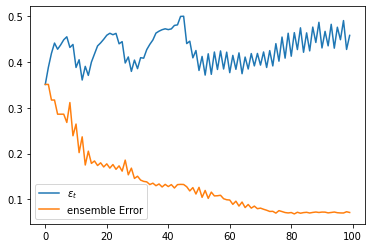

In [74]:
plt.plot(adaboost.errorHist, label="$\epsilon_t$")
plt.plot(adaboost.ensembleHist, label="ensemble Error")
plt.legend()

In [73]:
train_err = np.sum(y_train != y_train_) / len(y_train)
test_err = np.sum(y_test_ != y_test) / len(y_test)

print("training error: {:.4f}\ntest error:{:.4f}".format(train_err, test_err))

training error: 0.0716
test error:0.1035


# Testing on the weakest of the weak learners

We now want to experiment with a VERY weak learner. The weak learner works as follows:

- it creates a random linear model by generating the needed weight vector $\mathbf{w}$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [75]:
class RandomLinearModel:
    def loss(self, y, y_, w):
        return np.sum(w[y != y_])
        
    def fit(self,X,y,sample_weight=None):
        self.w = (np.random.rand(X.shape[1]) - 0.5) * 2
        y_ = self.predict(X)

        if self.loss(y, y_, sample_weight) > 0.5:
            self.w = -self.w

        return self

    def predict(self,X):
        return np.sign(np.matmul(X, self.w))

Let us now learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble. Evaluate the training and test error of the final ensemble model.

In [79]:
rs = RandomLinearModel()
a = AdaBoost(rs,100000)
a.fit(X_train,y_train)

y_train_ = a.predict(X_train)
y_test_ = a.predict(X_test)

Step:1000
----------
error_t: 0.4996
ensemble error: 0.3960
----------

Step:2000
----------
error_t: 0.4992
ensemble error: 0.3618
----------

Step:3000
----------
error_t: 0.4957
ensemble error: 0.3265
----------

Step:4000
----------
error_t: 0.4963
ensemble error: 0.3031
----------

Step:5000
----------
error_t: 0.4964
ensemble error: 0.2779
----------

Step:6000
----------
error_t: 0.4997
ensemble error: 0.2632
----------

Step:7000
----------
error_t: 0.4961
ensemble error: 0.2474
----------

Step:8000
----------
error_t: 0.4974
ensemble error: 0.2258
----------

Step:9000
----------
error_t: 0.4973
ensemble error: 0.2149
----------

Step:10000
----------
error_t: 0.4996
ensemble error: 0.2000
----------

Step:11000
----------
error_t: 0.4956
ensemble error: 0.1866
----------

Step:12000
----------
error_t: 0.4993
ensemble error: 0.1708
----------

Step:13000
----------
error_t: 0.4954
ensemble error: 0.1605
----------

Step:14000
----------
error_t: 0.4946
ensemble error: 0.1512

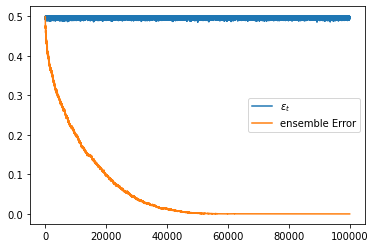

In [82]:
plt.plot(a.errorHist, label="$\epsilon_t$")
plt.plot(a.ensembleHist, label="ensemble Error")
plt.legend()

In [81]:
train_err = np.sum(y_train != y_train_) / len(y_train)
test_err = np.sum(y_test_ != y_test) / len(y_test)

print("training error: {:.4f}\ntest error:{:.4f}".format(train_err, test_err))

training error: 0.0000
test error:0.5108
